# West Nile Analysis

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,  AdaBoostClassifier
from sklearn.cross_validation import train_test_split, KFold, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/bryancombs/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
train = pd.read_csv('../data/trainw.csv')
test  = pd.read_csv('../data/testw.csv')
train.columns = [col.lower().replace(' ', '_') for col in train.columns]
test.columns = [col.lower().replace(' ', '_') for col in test.columns]


#read cleaned data and bring and trainform all variables to lower_camel_case
                    

In [3]:
train.isnull().sum() 


unnamed:_0                                0
address                                   0
addressaccuracy                           0
addressnumberandstreet                    0
avgspeed_x                                0
avgspeed_y                                0
block                                     0
codesum_x                                 0
codesum_y                                 0
cool_x                                    0
cool_y                                    0
date                                      0
day                                       0
depart_x                                  0
depart_y                                  0
depth_x                                   0
depth_y                                   0
dewpoint_x                                0
dewpoint_y                                0
distance                                  0
heat_x                                    0
heat_y                                    0
index                           

In [4]:
#included features to set up X and Y from training set
features = [ 'trap', 'block', 'month', 'street', 
             
            'tmax_y', 
            'tavg_y', 'dewpoint_y',
            'preciptotal_y', 'stnpressure_y',
            'sealevel_y', 'resultspeed_y', 'resultdir_y', 'avgspeed_y', 'distance',
            'dist_species_culex_pipiens',
            'dist_species_culex_pipiens/restuans', 'dist_species_culex_restuans',
            'dist_species_culex_salinarius', 
            'dist_species_culex_territans',
            'month_dist_temp_y',
            'month_and_dist'
            
           ]
X = train[features]
y = train['wnvpresent']

In [5]:
#do a train test split with stratified data due to unbalanced classes

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 6, stratify = y)

#### Dealing with unbalanced classes

We have unbalanced classes in our data set with only about 5.24% of our observations containing the West Nile Virus.  In order to better predict the minority class which is the class of interest we are oversampling the data where West Nile is present in our training data.  We leave the testing data untouched.

In [6]:
#merging the target variable back onto the training data in order to sample off its value

datasets = (X_train, y_train)
traincombined = pd.concat(datasets, axis = 1)
traincombined.head()

,trap,block,month,street,tmax_y,tavg_y,dewpoint_y,preciptotal_y,stnpressure_y,sealevel_y,...,avgspeed_y,distance,dist_species_culex_pipiens,dist_species_culex_pipiens/restuans,dist_species_culex_restuans,dist_species_culex_salinarius,dist_species_culex_territans,month_dist_temp_x,month_and_dist,wnvpresent
10477,76,0,9.0,62,75,65,52,0.00,29.40,30.04,...,4.6,0.488413,0.000000,0.000000,0.488413,0.0,0.0,276.930395,4.395721,0.0
1929,11,41,8.0,121,81,77,69,0.83,29.23,29.87,...,7.1,0.539636,0.539636,0.000000,0.000000,0.0,0.0,328.098834,4.317090,0.0
6,33,12,5.0,123,88,77,59,0.00,29.44,30.09,...,7.4,0.358443,0.000000,0.000000,0.358443,0.0,0.0,132.624089,1.792217,0.0
3078,9,21,9.0,39,66,56,43,0.00,29.46,30.11,...,6.0,1.771727,0.000000,1.771727,0.000000,0.0,0.0,908.895877,15.945542,1.0
3279,40,10,9.0,133,89,78,57,0.00,29.41,30.05,...,12.8,0.622362,0.000000,0.622362,0.000000,0.0,0.0,425.695939,5.601262,0.0


In [7]:
#Select West nile cases and generate 5000 samples
west_nile = traincombined[traincombined.wnvpresent == 1]
extra_west_nile = west_nile.sample(n = 5000, replace = True, random_state = 63, axis = 0)

In [8]:
#merge samples onto original data
merge = [traincombined, extra_west_nile]
traincombined = pd.concat(merge, axis = 0)

In [9]:
#Break our training data back into a X and a y
X_train = traincombined[features]
y_train = traincombined['wnvpresent']

### Set up our model for grid search evaluation

In [10]:
ad = AdaBoostClassifier()
rf_params = {
    'n_estimators'       : [  400, ],
    'learning_rate'          : [ .9  ]
   }



In [11]:
gs = GridSearchCV(ad, 
                  param_grid=rf_params,
                 scoring = 'recall', 
                  cv = 4)


In [12]:
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)
print(gs.score(X_test, y_test))


0.8041751732000215
{'learning_rate': 0.9, 'n_estimators': 400}
0.6594202898550725


In [13]:
y_hat = gs.predict(X_test)
y_hat_train = gs.predict(X_train)
y_hat_prob = gs.predict_proba(X_test)


In [14]:
ad.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [15]:
ad.feature_importances_

array([0.14, 0.02, 0.06, 0.02, 0.12, 0.02, 0.04, 0.04, 0.04, 0.02, 0.06,
       0.04, 0.08, 0.02, 0.04, 0.04, 0.06, 0.02, 0.02, 0.04, 0.06])

In [16]:
print(classification_report( y_train, y_hat_train))

             precision    recall  f1-score   support

        0.0       0.85      0.82      0.84      7466
        1.0       0.77      0.81      0.79      5413

avg / total       0.82      0.82      0.82     12879



In [17]:
print(classification_report(y_test, y_hat))

             precision    recall  f1-score   support

        0.0       0.98      0.80      0.88      2489
        1.0       0.16      0.66      0.25       138

avg / total       0.93      0.80      0.85      2627



In [18]:
confusion_matrix(y_train, y_hat_train)

array([[6142, 1324],
       [1054, 4359]])

In [19]:
confusion_matrix(y_test, y_hat)

array([[2001,  488],
       [  47,   91]])

In [20]:
y_test.value_counts()

0.0    2489
1.0     138
Name: wnvpresent, dtype: int64

In [21]:
X = test[features]
predict = (gs.predict(X))
predprob = gs.predict_proba(X)

In [22]:
predprob

array([[0.52429773, 0.47570227],
       [0.52517108, 0.47482892],
       [0.52410895, 0.47589105],
       ...,
       [0.50290862, 0.49709138],
       [0.50290862, 0.49709138],
       [0.50290862, 0.49709138]])

In [23]:
y_train_pred_proba = gs.predict_proba(X_train)
y_train_pred = gs.predict(X_train)
y_test_pred_proba = gs.predict_proba(X_test)
y_test_pred = gs.predict(X_test)

In [24]:
#modifying train and testing data to allow for changing prob thresholds and printing the 
#roc curves
X_train.loc[:, 'actual_y'] = y_train
X_train.loc[:, 'predicted_label'] = y_train_pred
X_train.loc[:, 'predicted_proba'] = y_train_pred_proba[:, 1]


In [25]:
X_test.loc[:, 'actual_y'] = y_test
X_test.loc[:, 'predicted_label'] = y_test_pred
X_test.loc[:, 'predicted_proba'] = y_test_pred_proba[:, 1]


In [26]:
#print out confusion matrices from .1 .5 by .02 for Xtest and Xtrain
for prob in range(10, 50, 2):
    proba = prob/100
    
    X_test.loc[:, 'predicted_label']= X_test['predicted_proba'].map(
    lambda p: 1 if p > proba else 0)
    
    X_train.loc[:, 'predicted_label']= X_train['predicted_proba'].map(
    lambda p: 1 if p > proba else 0)
    
    X_test['predicted_label']
    print('Test  ' + str(proba))
    print(confusion_matrix(y_test, X_test['predicted_label']))
    print(' Train  ' + str(proba))
    print(confusion_matrix(y_train, X_train['predicted_label']))


Test  0.1
[[   0 2489]
 [   0  138]]
 Train  0.1
[[   0 7466]
 [   0 5413]]
Test  0.12
[[   0 2489]
 [   0  138]]
 Train  0.12
[[   0 7466]
 [   0 5413]]
Test  0.14
[[   0 2489]
 [   0  138]]
 Train  0.14
[[   0 7466]
 [   0 5413]]
Test  0.16
[[   0 2489]
 [   0  138]]
 Train  0.16
[[   0 7466]
 [   0 5413]]
Test  0.18
[[   0 2489]
 [   0  138]]
 Train  0.18
[[   0 7466]
 [   0 5413]]
Test  0.2
[[   0 2489]
 [   0  138]]
 Train  0.2
[[   0 7466]
 [   0 5413]]
Test  0.22
[[   0 2489]
 [   0  138]]
 Train  0.22
[[   0 7466]
 [   0 5413]]
Test  0.24
[[   0 2489]
 [   0  138]]
 Train  0.24
[[   0 7466]
 [   0 5413]]
Test  0.26
[[   0 2489]
 [   0  138]]
 Train  0.26
[[   0 7466]
 [   0 5413]]
Test  0.28
[[   0 2489]
 [   0  138]]
 Train  0.28
[[   0 7466]
 [   0 5413]]
Test  0.3
[[   0 2489]
 [   0  138]]
 Train  0.3
[[   0 7466]
 [   0 5413]]
Test  0.32
[[   0 2489]
 [   0  138]]
 Train  0.32
[[   0 7466]
 [   0 5413]]
Test  0.34
[[   0 2489]
 [   0  138]]
 Train  0.34
[[   0 7466]
 [   0

In [27]:
fpr, tpr, _ = roc_curve(y_train, X_train['predicted_proba'])
roc_auc = auc(fpr, tpr)


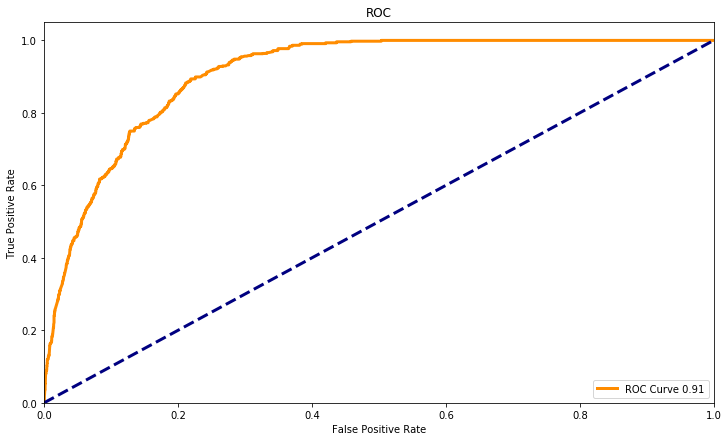

In [28]:
# Plot 
plt.figure(figsize = (12,7))
line_width = 3

plt.plot(fpr, tpr, lw = line_width, color="darkorange", label = "ROC Curve %.2f" % roc_auc)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [29]:
fpr, tpr, _ = roc_curve(y_test, X_test['predicted_proba'])
roc_auc = auc(fpr, tpr)

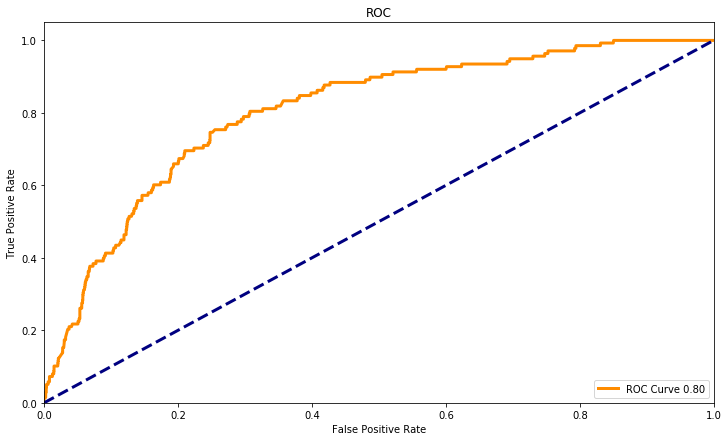

In [30]:
# Plot 
plt.figure(figsize = (12,7))
line_width = 3

plt.plot(fpr, tpr, lw = line_width, color="darkorange", label = "ROC Curve %.2f" % roc_auc)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [31]:
rf_predict = gs.predict(X)
rf_proba = gs.predict_proba(X)[:,1]

In [32]:
rf_proba

array([0.47570227, 0.47482892, 0.47589105, ..., 0.49709138, 0.49709138,
       0.49709138])

In [33]:
submissions = pd.DataFrame(rf_predict, columns = ['wnvpresent'])
submissions['predproba'] = rf_proba
submissions.loc[:, 'wnvpresent']= submissions['predproba'].map(
    lambda p: 1 if p > .5 else 0)

In [34]:
submissions.wnvpresent.value_counts()

0    109410
1      6883
Name: wnvpresent, dtype: int64

In [35]:
submissions['id'] = [id +1 for id in range(len(submissions))]

In [36]:
submissions = submissions[['id','wnvpresent' ]]


In [37]:
submissions.to_csv('../data/submission.csv', index = False)